# ネットワークデータの読み込み

In [44]:
import pypsa

# 最適化済みネットワークデータを読み込む
network = pypsa.Network('./complete_network/optimized_network_2024.nc')
print(f"ネットワークデータを読み込みました: {len(network.buses)} buses, {len(network.generators)} generators")

INFO:pypsa.network.io:New version 1.0.4 available! (Current: 1.0.3)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, links, loads, stores, sub_networks


ネットワークデータを読み込みました: 49 buses, 210 generators


c:\Users\takashi-yanase\AppData\Local\miniconda3\envs\pypsa_tepsco\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



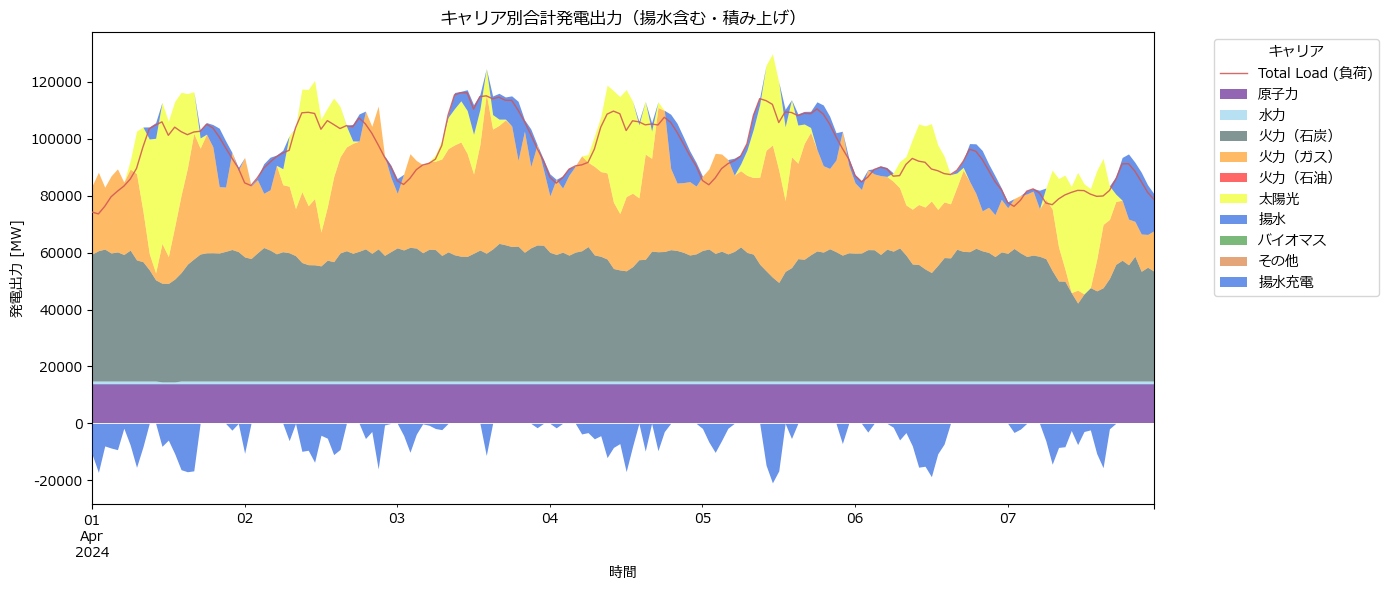

In [41]:
# 需給シミュレーション結果を表示
import src.analyze_results as analyze_results
import importlib
# モジュールを強制的にリロード
importlib.reload(analyze_results)
analyze_results.plot_total_generation_by_carrier(network)

ネットワーク内のcarrier一覧:
['その他', 'バイオマス', '原子力', '太陽光', '水力', '火力（ガス）', '火力（石油）', '火力（石炭）']


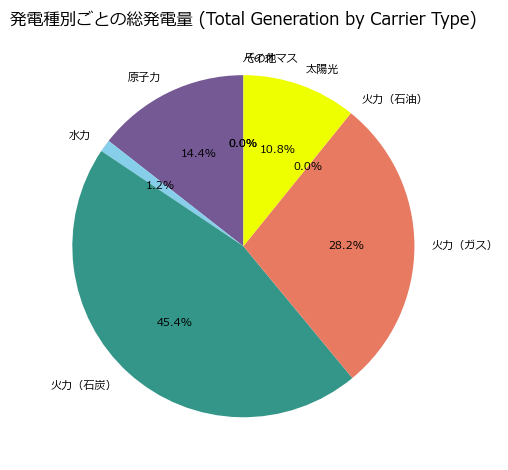

In [42]:
# 需給シミュレーション結果を表示
import src.analyze_results as analyze_results
import importlib
# モジュールを強制的にリロード
importlib.reload(analyze_results)
analyze_results.plot_generation_mix_in_total_in_pie_graph(network)

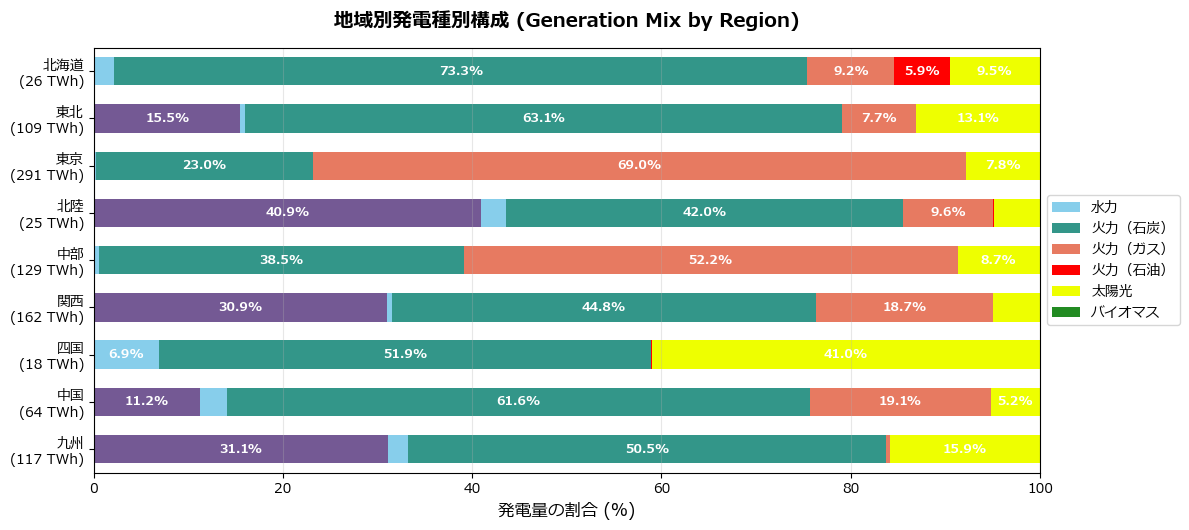

In [52]:
# 地域別発電量構成
import src.analyze_results as analyze_results
import importlib
# モジュールを強制的にリロード
importlib.reload(analyze_results)

analyze_results.plot_generation_by_bus(network)

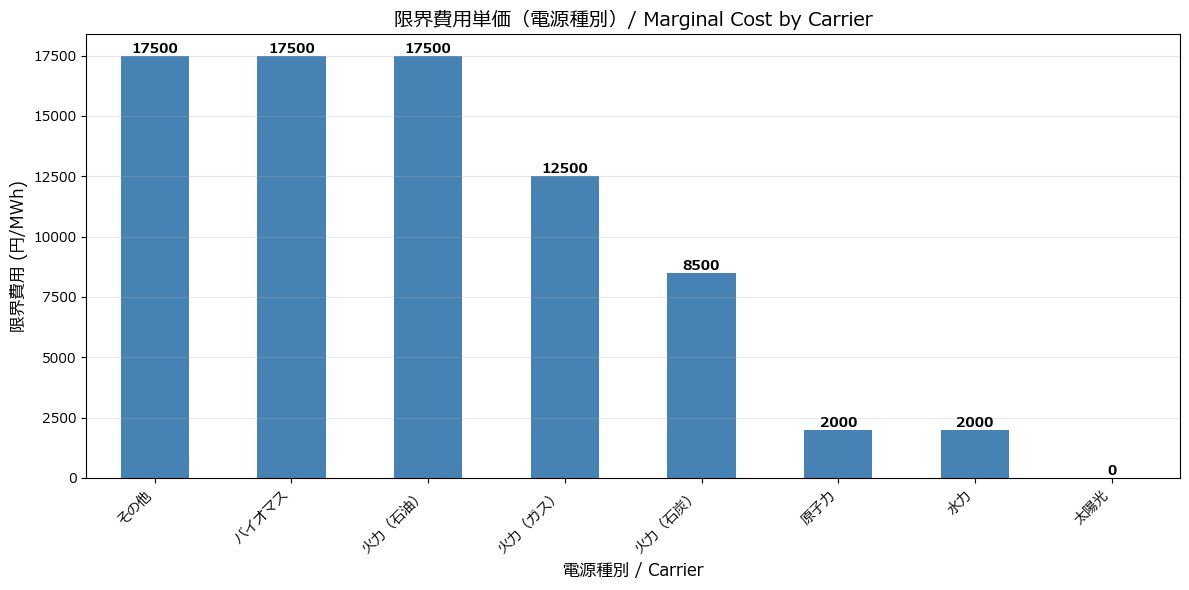


電源種別ごとの限界費用単価:
carrier
その他       17500.0
バイオマス     17500.0
火力（石油）    17500.0
火力（ガス）    12500.0
火力（石炭）     8500.0
原子力        2000.0
水力         2000.0
太陽光           0.0
Name: marginal_cost, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 電源種別ごとの限界費用単価を取得
marginal_costs = network.generators.groupby('carrier')['marginal_cost'].first()

# 限界費用でソート
marginal_costs = marginal_costs.sort_values(ascending=False)

# 棒グラフで表示
fig, ax = plt.subplots(figsize=(12, 6))
bars = marginal_costs.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('限界費用単価（電源種別）/ Marginal Cost by Carrier', fontsize=14)
ax.set_ylabel('限界費用 (円/MWh)', fontsize=12)
ax.set_xlabel('電源種別 / Carrier', fontsize=12)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# 各棒グラフの上に数値を表示
for i, (idx, value) in enumerate(marginal_costs.items()):
    ax.text(i, value, f'{value:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 数値も表示
print("\n電源種別ごとの限界費用単価:")
print(marginal_costs)


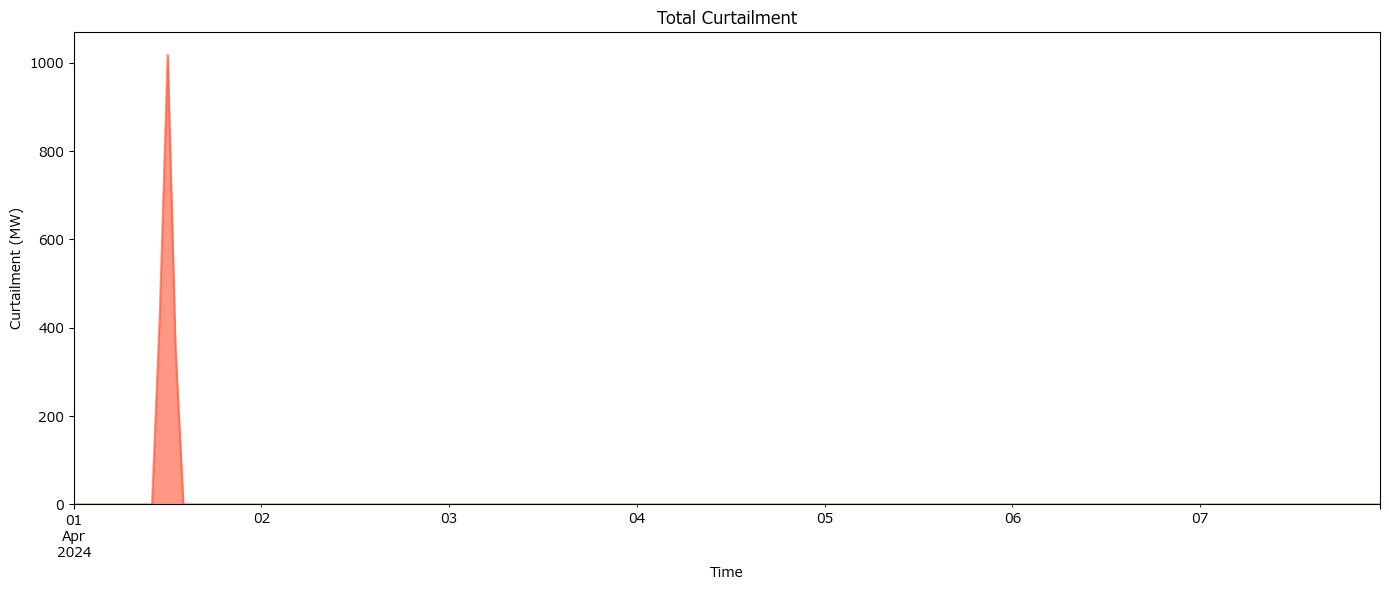

In [43]:
import matplotlib.pyplot as plt

# ネットワークの出力抑制（curtailment）を計算して表示
curtailment = network.generators_t.p_max_pu * network.generators.p_nom - network.generators_t.p

# 時系列の出力抑制をプロット
curtailment_positive = curtailment.clip(lower=0)
fig, ax = plt.subplots(figsize=(14, 6))
curtailment_positive.sum(axis=1).plot.area(ax=ax, title='Total Curtailment',
                                       ylabel='Curtailment (MW)', xlabel='Time', 
                                       stacked=True, color='#FF6347AA')
plt.tight_layout()
plt.show()

# 送電線の潮流を表示

プロット対象の連系線: 10本
['北海道本州連系設備', '東北東京間連系線', '東京中部間連系線', '中部北陸連系設備', '中部関西連系線', '北陸関西連系線', '関西中国間連系線', '関西四国間連系設備', '中国四国間連系線', '中国九州間連系線']


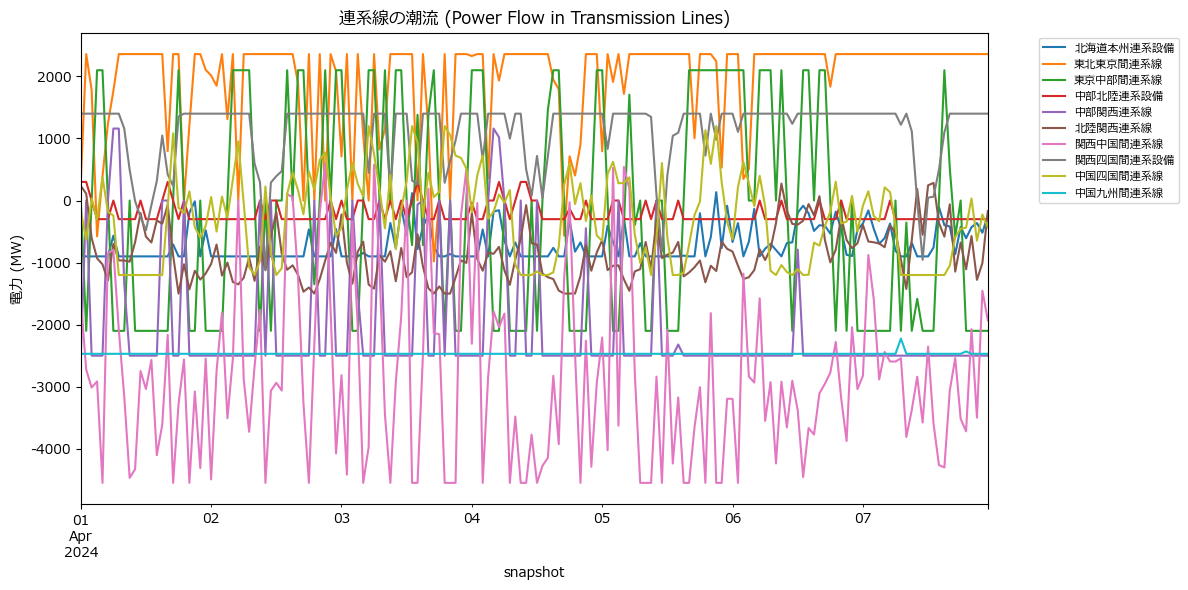

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.plotting.backend = "matplotlib"  # プロットバックエンドをmatplotlibに
plt.rcParams['font.family'] = 'Meiryo'  # または 'Meiryo', 'Yu Gothic' MS Gothic
plt.rcParams['axes.unicode_minus'] = False  # マイナス符号も文字化け防止

# 連系線のみをフィルタリング（carrier='DC'または名前に'連系'を含むリンク）
transmission_links = network.links[
    (network.links['carrier'] == 'DC') | 
    (network.links.index.str.contains('連系', na=False))
].index

if len(transmission_links) > 0:
    network.links_t.p0[transmission_links].plot(
        title="連系線の潮流 (Power Flow in Transmission Lines)", 
        figsize=(12, 6),
        ylabel="電力 (MW)"
    )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    print(f"プロット対象の連系線: {len(transmission_links)}本")
    print(transmission_links.tolist())
else:
    print("連系線が見つかりませんでした")

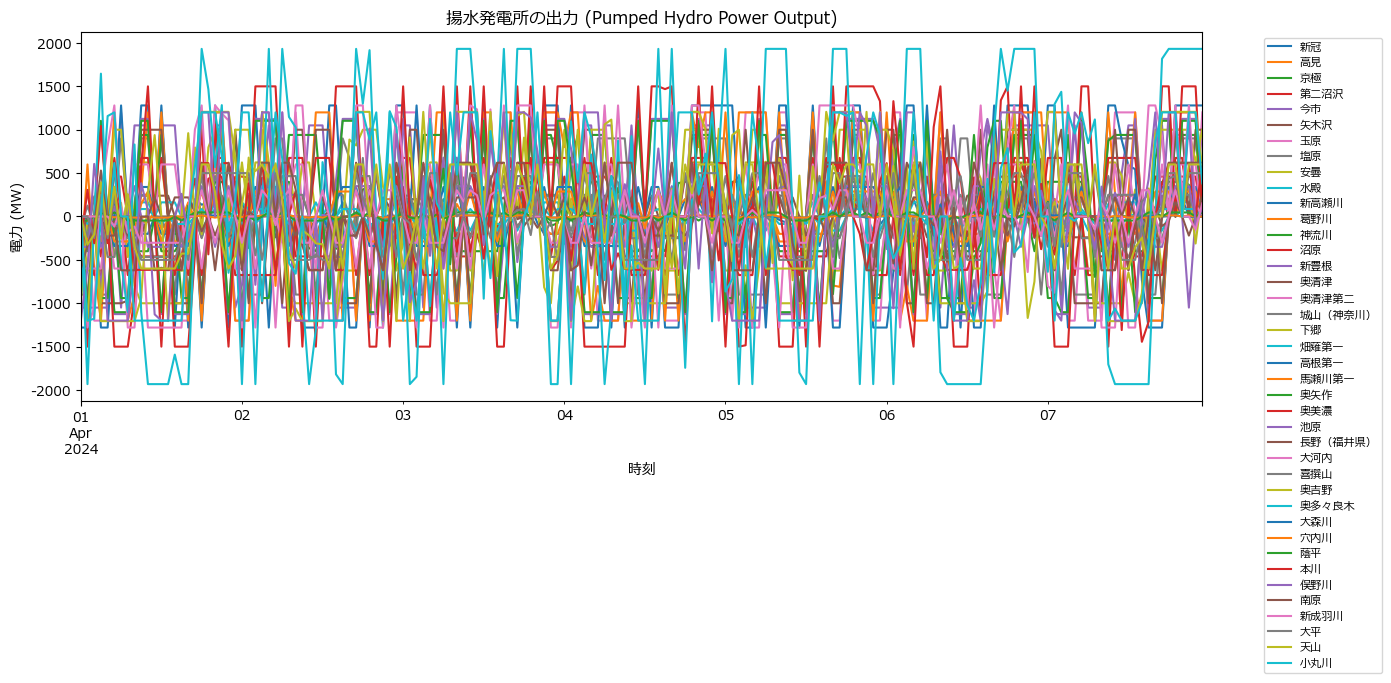

In [34]:
# 揚水発電所のリンクを特定
pumped_hydro_links = network.links[network.links['carrier'] == '揚水'].index

# 揚水発電所の出力時系列データを取得
pumped_hydro_power = network.links_t.p0[pumped_hydro_links]

# 揚水発電所のリンク（発電・揚水）の出力をプロット
if len(pumped_hydro_links) > 0:
    fig, ax = plt.subplots(figsize=(14, 6))
    pumped_hydro_power.plot(ax=ax, title='揚水発電所の出力 (Pumped Hydro Power Output)', 
                            ylabel='電力 (MW)', xlabel='時刻', legend=False)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print("揚水発電所のリンクが見つかりませんでした")

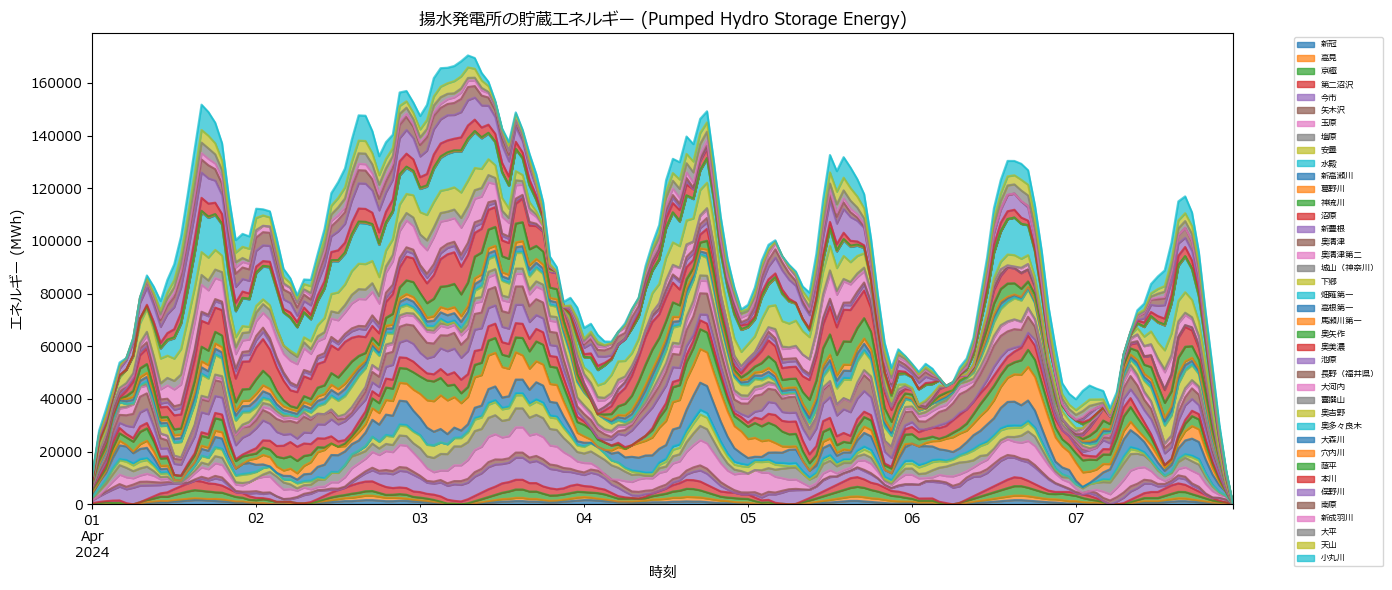

In [15]:
# 揚水発電所の貯蔵エネルギー（蓄電状態）を積み上げグラフでプロット
if len(network.stores) > 0:
    # 揚水発電所（Store）の蓄電量時系列データを取得
    storage_energy = network.stores_t.e
    
    if not storage_energy.empty:
        fig, ax = plt.subplots(figsize=(14, 6))
        storage_energy.plot(
            ax=ax, 
            kind='area',
            stacked=True,
            alpha=0.7,
            title='揚水発電所の貯蔵エネルギー (Pumped Hydro Storage Energy)', 
            ylabel='エネルギー (MWh)', 
            xlabel='時刻'
        )
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=6)
        plt.tight_layout()
        plt.show()
    else:
        print("揚水発電所の貯蔵エネルギーデータがありません")
else:
    print("ネットワークに揚水発電所（Store）が含まれていません")

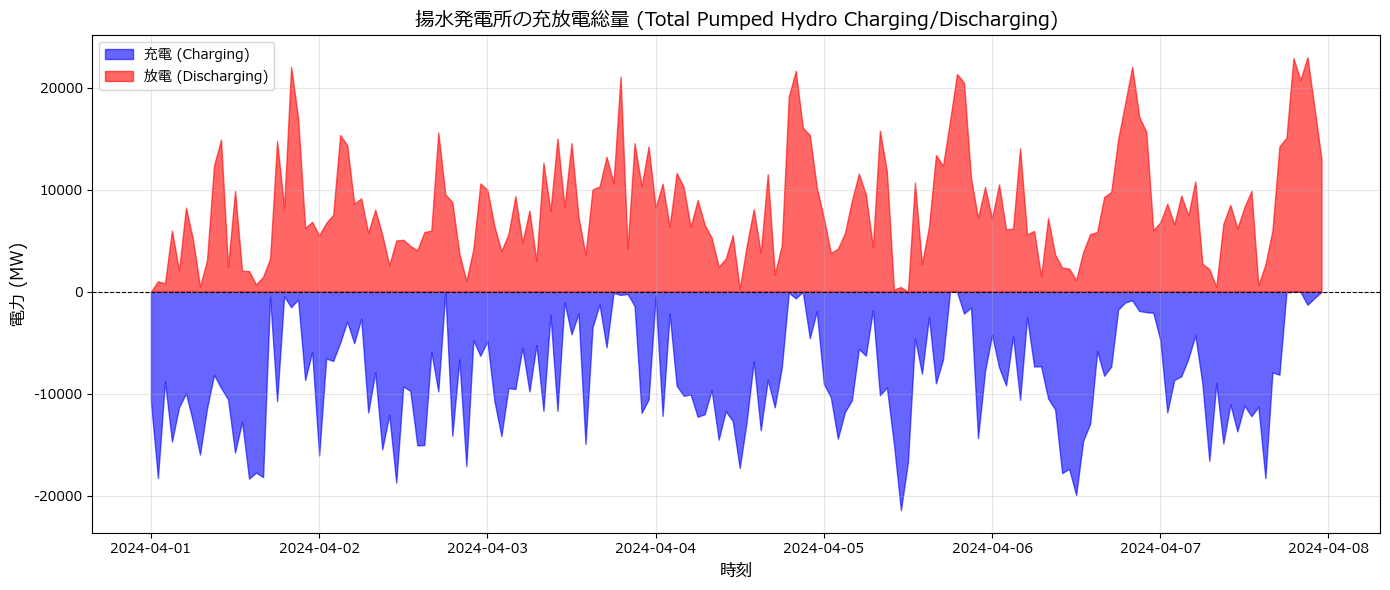

In [16]:
# 揚水発電所の充電（負値）と放電（正値）を分けて集計してプロット
# 充電量（負の値）と放電量（正の値）を分離
charging = pumped_hydro_power.clip(upper=0).sum(axis=1)  # 負の値（充電）
discharging = pumped_hydro_power.clip(lower=0).sum(axis=1)  # 正の値（放電）
  
# プロット
fig, ax = plt.subplots(figsize=(14, 6))
ax.fill_between(charging.index, charging, 0, alpha=0.6, color='blue', label='充電 (Charging)')
ax.fill_between(discharging.index, 0, discharging, alpha=0.6, color='red', label='放電 (Discharging)')
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_title('揚水発電所の充放電総量 (Total Pumped Hydro Charging/Discharging)', fontsize=14)
ax.set_ylabel('電力 (MW)', fontsize=12)
ax.set_xlabel('時刻', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
